# The Non Random Two Liquids (NRTL) model for *excess Gibbs energy* ($g^E$) and a case study of Liquid-Liquid equilibria of limonene+water+ethanol

In [31]:
import numpy as np

In [32]:
from scipy.constants import R

# The model
as presented previously, in numpy/numba format

In [33]:
from numba import jit
@jit
def Gamma(T,c_x,q_alpha, q_A):
    q_tau     = q_A/T
    q_G       = np.exp(-(q_alpha*q_tau))
    l_D       = ((1/((q_G.T) @ c_x)).T)
    q_E       = (q_tau*q_G) * l_D 
    gamma     = np.exp(((q_E+(q_E.T))-(((q_G * l_D) * (c_x.T)) @ (q_E.T))) @ c_x)
    return gamma

# fited parameters
Experimental parameters from Cháfer et al., 2004

Ref: Cháfer, Muñoz, Burguet, Berna, The influence of the temperature on the liquid–liquid equlibria of the mixture limonene + ethanol + $\mathrm {H_2O}$, Fluid Phase Equilibria 224 (2004) 251–256

d-limonene (1) + ethanol (2) + water (3)

In [34]:
# d-limonene (1) + ethanol (2) + water (3)

alpha12=alpha13=alpha23=alpha21=alpha31=alpha23=0.2;


A12=107.99
A21=555.81
A13=1011.98
A31=2277.37
A23=-1113.1
A32=1217.37

## Feeding the fitted parameters to the model in matrix structure:
we will assemble the parameters in a matrix structure so that we can access each parameter by its index, as in
`A[0,0]` and `A[0,1]`rather than as `A11` and `A12`, so we can loop trough all of them using an iterator, see below:

In [35]:
alpha = np.array([[0, alpha12, alpha13],
                [alpha12, 0, alpha23],
                [alpha13, alpha23, 0]])

A = np.array([[0, A12, A13],
             [A21, 0, A23],
             [A31, A32, 0]])

# Liq-Liq Equilibria Flash
The next step will be using the model in a phase equilibria algorithm, a Liq-Liq equilibria flash calculation

it works as follows:

The degrees of Freedom for a flash calculation are temperature - T, pressure - P and global composition - z


XXX img src from thesis XXX
* ...............  =>guess, xL1 xL2, then calls model(T,P,x)
* ...............//
* .............<=
* T,P,z => algorithm => finds equilibrium xL1 xL2 and BETA

**Equilibriuma criteria**

$$\mu_{i}^{\rm {L1}}=\mu_{i}^{\rm {L2}}, \forall i$$

**Devised algorithm after analytical simplification of repeated contributions:**

$$x_{i}^{\rm {L1}} \gamma_{i}^{\rm {L1}}= x_{i}^{\rm {L2}} \gamma_{i}^{\rm {L2}}, \forall i$$

# algorithm
based on Rachford and Rice (1952) approach to LV equilibrium


Ref: Rachford HH, Rice JD, Petroleum Trans AIME 1952;195:327-328

In [216]:
def ELLflash_explicit(Z,beta0,K0,MODEL):
    
    #copy intial guesses to local variables
    beta=beta0.copy()
    K=K0.copy()

    converged = 0 # flag indicating not converged yet
    
    #initialize local arrays
    a = np.zeros(3)
    XI = np.zeros(3)
    XII = np.zeros(3)
    
    looped3=0
    
    #managing loop for fixed point point algorithm
    looping2 = 0
    while ( (looping2 == 0) # means do at least once
           or ((ResK)>0.0001 # convergence criteria
               and looping2 < 100) ): # max number of iterations

        prevK = K.copy()
        
        #print(np.may_share_memory(K,prevK))
        
        #Solve RachfordRice equation with a newton raphson loop
        looping3 = 0
        while ( (looping3 == 0) # means do at least once
               or ((ResBeta)>0.0001 # convergence criteria
                   and looping3 < 100) ): #max number of iterations
            
            prevbeta = beta.copy()

            for i in range(3):
                a[i] = ( (K[i]-1) / (1+beta*(K[i]-1)) )            
                
            R=0 #residue funtion (F)
            for j in range(3):
                R+=Z[j]*a[j]

            J=0 #jacobian (Fprime)
            for j in range(3):
                J-=Z[j]*a[j]*a[j]
                            
            beta -= R/J #NR step

            if ~(0<=beta<=1): #divergence, propably there is no LLE at this Z
                return Z, np.zeros(3), np.array([[0]]), 0
            
            ResBeta = beta[0,0]-prevbeta[0,0]
            
            looping3 += 1        
        
        looped3+= looping3

        for i in range(3):
            XI[i] = Z[i] * (1./(1+beta * (K[i]-1))) #Rachford-Rice composition updating scheme
                
        gamaI = MODEL(XI/np.sum(XI)) #enforce normalization in the MODEL call
        
        for i in range(3):
            XII[i] = K[i]*XI[i]

        gamaII = MODEL(XII/np.sum(XII)) #enforce normalization in the MODEL call
        
        for i in range(3):
            K[i] = (gamaI[i])/(gamaII[i]) #definition of K
        
        ResK=0
        for i in range(3):
            ResK += np.sqrt((prevK[i]-K[i])**2)
        looping2 += 1    

    #print('Calculation has ended')
    if (looping2 < 100 and looping3 < 100 and (0.<beta[0,0]<1.) ):
        converged = looped3 #looping2
    
    return XI, XII, beta, converged

In [217]:
#test
ztest=np.array([[0.3000,
0.4000,
0.3000]]).T

betatest=np.array([[0.2966]])

xitest=np.array([[0.0535,
0.5250,
0.4215]]).T


xiitest=np.array([[0.8845,
0.1035,
0.0120]]).T

ktest=1/(xitest/xiitest)

beta0=betatest
k0=ktest
Z=ztest

T  = 293.15
MODEL = lambda x: Gamma(T,x,alpha,A)

ans=ELLflash_explicit(Z,beta0,k0,MODEL)

print('at T', T, 'Z', Z)
print('with ig of', k0, beta0)
print('solution is')
print(ans[0])
print(ans[1])
print(ans[2])
print(ans[3])

at T 293.15 Z [[ 0.3]
 [ 0.4]
 [ 0.3]]
with ig of [[ 16.53271028]
 [  0.19714286]
 [  0.02846975]] [[ 0.2966]]
solution is
[ 0.05351624  0.52503406  0.4214497 ]
[ 0.88451339  0.10349332  0.01199329]
[[ 0.29661204]]
7


In [218]:
%timeit ans=ELLflash_explicit(Z,beta0,k0,MODEL)

The slowest run took 7.45 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 1.66 ms per loop


In [219]:
def ELLflash(Z,beta0,K0,MODEL): #ELLflash_linalg
    
    beta=beta0.copy()
    K=K0.copy()
    
    converged = 0

    looped3 = 0
    
    looping2 = 0
    while ( (looping2 == 0) # means do at least once
           or ((ResK)>0.0001 # convergence criteria
               and looping2 < 100) ): # max number of iterations

        prevK = K.copy()        
        
        looping3 = 0
        while ( (looping3 == 0)
               or (ResBeta>0.0001 # convergence criteria
                   and looping3 < 100) ): #max number of iterations
            
            prevbeta = beta.copy()
            
            a = (1/(1+beta*(K-1))) * (K-1)
            beta = beta+(1/((Z.T*a.T) @ a)) @ (Z.T @ a)

            if ~(0<=beta<=1): #divergence, propably there is no LLE at this Z
                return Z, np.zeros(3), np.array([[0]]), 0
            
            ResBeta = beta[0,0]-prevbeta[0,0]
            
            looping3 += 1
            
        looped3 += looping3


        XI = (1./(1+beta * (K-1))) * Z

        gamaI = MODEL(XI/np.sum(XI))
        
        XII = K*XI

        gamaII = MODEL(XII/np.sum(XII))
        
        K = (gamaI)/(gamaII)
        
        ResK = np.linalg.norm(K-prevK)
        
        looping2 += 1    

    #print('Calculation has ended')
    if (looping2 < 100 and looping3 < 100  and ( 0. <= beta[0,0] <= 1.)  ):
        converged = looped3 #looping2
    
    return XI, XII, beta, converged

In [230]:
#test
ztest=np.array([[0.3000,
0.4000,
0.3000]]).T

betatest=np.array([[0.2966]])

xitest=np.array([[0.0535,
0.5250,
0.4215]]).T


xiitest=np.array([[0.8845,
0.1035,
0.0120]]).T


ktest=1/(xitest/xiitest)

beta0=betatest
k0=ktest
Z=ztest

T  = 293.15
MODEL = lambda x: Gamma(T,x,alpha,A)

ans=ELLflash(Z,beta0,k0,MODEL)

print('at T', T, 'Z', Z)
print('with ig of', k0, beta0)
print('solution is')
print(ans[0])
print(ans[1])
print(ans[2])
print(ans[3])

at T 293.15 Z [[ 0.3]
 [ 0.4]
 [ 0.3]]
with ig of [[ 16.53271028]
 [  0.19714286]
 [  0.02846975]] [[ 0.2966]]
solution is
[[ 0.05351624]
 [ 0.52503406]
 [ 0.4214497 ]]
[[ 0.88451339]
 [ 0.10349332]
 [ 0.01199329]]
[[ 0.29661204]]
7


In [235]:
%timeit ans=ELLflash_explicit(Z,beta0,k0,MODEL)
ans=ELLflash_explicit(Z,beta0,k0,MODEL)
print(ans[3],ans[2])
%timeit ans=ELLflash_explicit(Z,2*beta0,k0/Z,MODEL)
ans=ELLflash_explicit(Z,2*beta0,k0/Z,MODEL)
print(ans[3],ans[2])
%timeit ans=ELLflash(Z,beta0,k0,MODEL)
ans=ELLflash(Z,beta0,k0,MODEL)
print(ans[3],ans[2])
%timeit ans=ELLflash(Z,2*beta0,k0/Z,MODEL)
ans=ELLflash(Z,2*beta0,k0/Z,MODEL)
print(ans[3],ans[2])

The slowest run took 7.87 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 1.66 ms per loop
7 [[ 0.29661204]]
100 loops, best of 3: 6.06 ms per loop
27 [[ 0.29661511]]
1000 loops, best of 3: 885 µs per loop
7 [[ 0.29661204]]
100 loops, best of 3: 3.4 ms per loop
27 [[ 0.29661511]]


# initial guess


In [12]:
#Estimativas Iniciais

def iguess(Z,MODEL):
    #print(Z)
    X0 = Z
    gama0 = MODEL(X0/np.sum(X0))
    
    Xlin = 1/(gama0.T @ Z) * (gama0*Z)

    gamalin = MODEL(Xlin/np.sum(Xlin))

    Klin = (1./gamalin) * gama0

    KlinMin = np.min(Klin)
    KlinMax = np.max(Klin)

    nI0 = (KlinMax - Klin) * Z

    XI0 = 1/(np.sum(nI0)) * nI0

    gamaI0=MODEL(XI0/np.sum(XI0))

    nII0=(Klin-KlinMin) * Z

    XII0=1/(np.sum(nII0)) * nII0;

    gamaII0=MODEL(XII0/np.sum(XII0))

    beta0 = np.array([[ 1/(KlinMax-KlinMin) * np.sum(nII0) ]])
    
    K0 = (gamaI0)/(gamaII0)
    
    return beta0, K0

In [13]:
ztest=np.array([[0.3000,
0.4000,
0.3000]]).T
betatest=0.2966
xitest=np.array([[0.0535,
0.5250,
0.4215]]).T
xiitest=np.array([[0.8845,
0.1035,
0.0120]]).T
ktest=1/(xitest/xiitest)

###

Z=ztest

print(T)
print(xitest*Gamma(T,xitest,alpha,A))
print(xiitest*Gamma(T,xiitest,alpha,A))

print('hue')
MODEL = lambda x: Gamma(T,x,alpha,A)

iguesses = iguess(Z,MODEL)

beta0 = iguesses[0]
K0 = iguesses[1]

print(beta0)
print(K0)

ans=ELLflash(Z,beta0,K0,MODEL)
print(ans[0])
print(ans[1])
print(ans[2])
print(ans[3])

293.15
[[ 0.9168827 ]
 [ 0.3519015 ]
 [ 0.17377495]]
[[ 0.91689205]
 [ 0.35194092]
 [ 0.17381633]]
hue
[[ 0.39441162]]
[[ 35.40198618]
 [  0.21977285]
 [  0.14735411]]
[[ 0.05351532]
 [ 0.52503359]
 [ 0.42145109]]
[[ 0.88450404]
 [ 0.10350028]
 [ 0.01199568]]
[[ 0.29661616]]
1


# grid calc plot

In [14]:
Z1 = np.linspace(0,1,10)
Z2 = np.linspace(0,1,10)
#Z3 = np.linspace(0,1,10)

Z1[0]=1e-9
Z2[0]=1e-9
#Z3[0]=1e-9

Z1[-1]=1-1e-9
Z2[-1]=1-1e-9
#Z3[-1]=1-1e-9

rawZs = np.ndarray((10,10), dtype=object)

flags = np.zeros((10,10))

for i in range(10):
    for j in range(10):
        rawZs[i,j]=np.array([Z1[i],Z2[j],1-Z1[i]-Z2[j]])
        if ( Z1[i] + Z2[j] <= 1 ):
            flags[i,j] = 1
        

            
Zs = rawZs[np.where(flags==1)]

npts = Zs.shape[0]
print(npts)

Resultados_beta = np.zeros([npts])
Resultados_conv = np.zeros([npts])
Resultados_Z = np.zeros([3,npts])
Resultados_XI = np.zeros([3,npts])
Resultados_XII = np.zeros([3,npts])

l=0
for k in range(npts):
    MODEL = lambda x: Gamma(T,x,alpha,A)
    beta0, K0 = iguess(np.array([Zs[k]]).T,MODEL)
    #print(beta0,K0)
    #print(Zs[k],beta0,K0)
    ans = ELLflash(np.array([Zs[k]]).T,beta0,K0,MODEL)
    
    if (0<ans[2] and 1>ans[2] and ans[3]==1):
        #print(ans[0][0][0],ans[0][1][0],ans[0][2][0])
        Resultados_XI[:,l] = np.array([ans[0][0][0],ans[0][1][0],ans[0][2][0]])
        Resultados_XII[:,l] = np.array([ans[1][0][0],ans[1][1][0],ans[1][2][0]])
        Resultados_beta[l] = ans[2]
        Resultados_conv[l] = ans[3]
        
        l+=1
        
    #print(ans[3], ans[2])
        
print('done',l)
    
ndone=l-1

55
done 26


In [15]:
fResultados_XI = Resultados_XI[:,np.where(Resultados_conv==1)]
fResultados_XII = Resultados_XII[:,np.where(Resultados_conv==1)]
fResultados_beta = Resultados_beta[np.where(Resultados_conv==1)]

In [16]:
print(Resultados_XI[:,3]) 

[ 0.03798202  0.47794287  0.48407511]


In [17]:
print(fResultados_XI[:,0,3])

[ 0.03798202  0.47794287  0.48407511]


In [18]:
from matplotlib import pyplot as plt


In [19]:
test_data1 = np.zeros([ndone,3])
test_data2 = np.zeros([ndone,3])


for k in range(ndone):
    #print(Resultados_XI[:,0])
    test_data1[k,0:3] = fResultados_XI[:,0,k]
    test_data2[k,0:3] = fResultados_XII[:,0,k]
    #test_data[l,3] = GM[l]


In [20]:

# barycentric coords: (a,b,c)
a=test_data1[:,0]
b=test_data1[:,1]
c=test_data1[:,2]

d=test_data2[:,0]
e=test_data2[:,1]
f=test_data2[:,2]


In [21]:
#determinar pto crítico
xcrit=0.4 #aprox.


#refiltrar a e b

al=a[np.where(a<=0.4)]
ar=a[np.where(a>0.4)]
dl=d[np.where(d<=0.4)]
dr=d[np.where(d>0.4)]

bl=b[np.where(a<=0.4)]
br=b[np.where(a>0.4)]
el=e[np.where(d<=0.4)]
er=e[np.where(d>0.4)]

In [22]:
Ly = np.concatenate((al,dl),axis=0)
Lx = np.concatenate((bl,el),axis=0)

Ry = np.concatenate((ar,dr),axis=0)
Rx = np.concatenate((br,er),axis=0)

sLy=np.sort(Ly)
sLx=np.sort(Lx)
sRy=np.sort(Ry)
sRx=-np.sort(-Rx)


plt.axis([0,1,0,1])
    
plt.scatter(Ly,Lx)    
plt.scatter(Ry,Rx)    

plt.plot(sLy,sLx)
plt.plot(sRy,sRx)

plt.show()

(25,) (25,) (25,) (25,)
(16,) (16,) (9,) (9,)
(9,) (9,) (16,) (16,)
(25,) (25,) (25,) (25,)


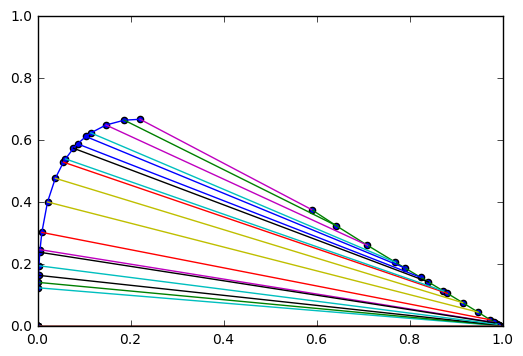

In [23]:
print(a.shape,b.shape,d.shape,e.shape)
print(al.shape,bl.shape,dl.shape,el.shape)
print(ar.shape,br.shape,dr.shape,er.shape)
print(Ly.shape,Ry.shape,Lx.shape,Rx.shape)

plt.axis([0,1,0,1])
    
plt.scatter(Ly,Lx)    
plt.scatter(Ry,Rx)    

plt.plot(sLy,sLx)
plt.plot(sRy,sRx)


for i in range(ndone):
    plt.plot([a[i],d[i]],[b[i],e[i]])



plt.show()
